![](https://i.gyazo.com/414881441edbabcf2ab32d3bdfc1711e.png)

In [62]:
# IMPORTS

import json
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
from tqdm import tqdm

unk = "<UNK>"

In [63]:
# Consult the PyTorch documentation for information on the functions used below:
# https://pytorch.org/docs/stable/torch.html

class FFNN(nn.Module):
    
    def __init__(self, input_dim, h):
        super(FFNN, self).__init__()
        
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.output_dim = 5
        self.W2 = nn.Linear(h, self.output_dim)

        self.activation = (
            nn.ReLU()
        )  # The rectified linear unit; one valid choice of activation function
        self.softmax = (
            nn.LogSoftmax()
        )  # The softmax function that converts vectors into probability distributions; computes log probabilities for computational benefits
        self.loss = (
            nn.NLLLoss()
        )  # The cross-entropy/negative log likelihood loss taught in class

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, input_vector):
        hidden_vector = self.activation(self.W1(input_vector))
        output_vector = self.W2(hidden_vector)
        predicted_vector = self.softmax(output_vector)
        return predicted_vector

In [64]:
def make_vocab(data):
    """
    Returns:
    vocab = A set of strings corresponding to the vocabulary, including the <UNK> token
    """
    return {word for document, _ in data for word in document} | {unk}

def make_indices(vocab):
    """
    Returns:
    vocab = A set of strings corresponding to the vocabulary including <UNK>
    word2index = A dictionary mapping word/token to its index (a number in 0, ..., V - 1)
    index2word = A dictionary inverting the mapping of word2index
    """
    vocab.remove(unk)
    vocab_list = sorted(vocab)
    
    word2index = {word: index for index, word in enumerate(vocab_list)}
    word2index[unk] = len(vocab_list)
    
    index2word = {index: word for index, word in enumerate(vocab_list)}
    index2word[len(vocab_list)] = unk
    
    vocab.add(unk)
    return word2index, index2word

In [65]:
def load_data(data):
    with open(data) as data_f:
        data_json = json.load(data_f)

    return [(elt["text"].split(), int(elt["stars"] - 1)) for elt in data_json]
    
def convert_to_vector_representation(data, word2index):
    """
    Returns:
    vectorized_data = A list of pairs (vector representation of input, y)
    """
    vectorized_data = []
    for document, y in data:
        vector = torch.zeros(len(word2index))
        for word in document:
            index = word2index.get(word, word2index[unk])
            vector[index] += 1
        vectorized_data.append((vector, y))
    return vectorized_data

### MAIN

In [66]:
from dataclasses import dataclass
from typing import List

@dataclass
class Args:
    """
    hidden_dim (int): hidden dimension
    epochs (int): number of epochs to train
    train_data (str): path to training data
    val_data (str): path to validation data
    test_data (str): path to test data
    """
    hidden_dims: List[int]
    epochs: int
    train_data: str
    val_data: str
    test_data: str = "to fill"
    
args = Args(
    hidden_dims=[32, 64, 128, 256, 512, 1024],
    epochs=10,
    train_data="training.json",
    val_data="validation.json",
    test_data="test.json",
)

In [67]:
# fix random seeds
random.seed(42)
torch.manual_seed(42)

In [68]:
# see if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [69]:
# load data | X_data is a list of pairs (document, y); y in {0,1,2,3,4}
train_data = load_data(args.train_data)
valid_data = load_data(args.val_data)

In [70]:
vocab = make_vocab(train_data)
word2index, index2word = make_indices(vocab)

In [71]:
# vectorizing data
train_data = convert_to_vector_representation(train_data, word2index)
valid_data = convert_to_vector_representation(valid_data, word2index)

In [72]:
# Stats about the data
print("Training Data Size:", len(train_data))
print("Validation Data Size:", len(valid_data))
print("Vocabulary Size:", len(vocab))

Training Data Size: 8000
Validation Data Size: 800
Vocabulary Size: 65667


In [73]:
def train_and_val(model):
    train_acc, val_acc = [], []
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    print("========== Training for {} epochs | h = {} ==========".format(args.epochs, model.h))

    for epoch in range(args.epochs):
        # Training
        model.train()
        # optimizer.zero_grad()
        
        # loss = None
        correct = total = 0
        random.shuffle(train_data)  # Good practice to shuffle order of training data
        N = len(train_data)
        minibatch_size = 16
        
        start_time = time.time()
        print("Training started for epoch {}".format(epoch + 1))
        for minibatch_index in tqdm(range(N // minibatch_size)):
            optimizer.zero_grad()
            loss = None
            
            for example_index in range(minibatch_size):
                input_vector, gold_label = train_data[
                    minibatch_index * minibatch_size + example_index
                ]
                predicted_vector = model(input_vector.to(device))
                predicted_label = torch.argmax(predicted_vector)
                correct += int(predicted_label == gold_label)
                total += 1
                example_loss = model.compute_Loss(
                    predicted_vector.view(1, -1), torch.tensor([gold_label]).to(device)
                )
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss
                    
            loss = loss / minibatch_size
            loss.backward()
            optimizer.step()
            
        print("Training completed for epoch {}".format(epoch + 1))
        print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        train_acc.append(correct / total)
        # print("Training time for this epoch: {}".format(time.time() - start_time))

        # Validation
        model.eval()
        # loss = None
        correct = total = 0
        N = len(valid_data)
        
        with torch.no_grad():
            start_time = time.time()
            print("Validation started for epoch {}".format(epoch + 1))
            for minibatch_index in tqdm(range(N // minibatch_size)):
                optimizer.zero_grad()
                loss = None
                
                for example_index in range(minibatch_size):
                    input_vector, gold_label = valid_data[
                        minibatch_index * minibatch_size + example_index
                    ]
                    predicted_vector = model(input_vector.to(device))
                    predicted_label = torch.argmax(predicted_vector)
                    correct += int(predicted_label == gold_label)
                    total += 1
                    example_loss = model.compute_Loss(
                        predicted_vector.view(1, -1), torch.tensor([gold_label]).to(device)
                    )
                    if loss is None:
                        loss = example_loss
                    else:
                        loss += example_loss
                        
                loss = loss / minibatch_size
                
            print("Validation completed for epoch {}".format(epoch + 1))
            print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
            val_acc.append(correct / total)
            # print("Validation time for this epoch: {}".format(time.time() - start_time))
    
    return train_acc, val_acc

In [74]:
def plot(train_acc, val_acc, hidden_dim):
    # Create an array for the number of epochs, e.g., [1, 2, 3, ...]
    epochs = np.arange(1, len(train_acc) + 1)

    # Plot training accuracy and validation accuracy on the same graph
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', linestyle='-')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='-')

    # Set axis labels and a legend
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Display the plot
    plt.xticks(np.arange(1, len(train_acc) + 1, step=1))
    plt.ylim(0, 1)
    plt.title('h = {} | Training and Validation Accuracy (by Epoch)'.format(hidden_dim))
    plt.show()

========== Training for 10 epochs | h = 32 ==========
Training started for epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]/home/spenupala/Github_Repos/Personal/UTD-College-CS-Coursework/CS_6320/assignment_2/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 500/500 [00:07<00:00, 62.74it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.533625
Validation started for epoch 1


100%|██████████| 50/50 [00:00<00:00, 125.56it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.5225
Training started for epoch 2


100%|██████████| 500/500 [00:07<00:00, 71.32it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.58375
Validation started for epoch 2


100%|██████████| 50/50 [00:00<00:00, 127.09it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.56625
Training started for epoch 3


100%|██████████| 500/500 [00:07<00:00, 69.71it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.61775
Validation started for epoch 3


100%|██████████| 50/50 [00:00<00:00, 127.74it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.60375
Training started for epoch 4


100%|██████████| 500/500 [00:07<00:00, 71.02it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.642
Validation started for epoch 4


100%|██████████| 50/50 [00:00<00:00, 127.50it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.5625
Training started for epoch 5


100%|██████████| 500/500 [00:07<00:00, 70.61it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.654875
Validation started for epoch 5


100%|██████████| 50/50 [00:00<00:00, 125.85it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.63125
Training started for epoch 6


100%|██████████| 500/500 [00:07<00:00, 67.35it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.677125
Validation started for epoch 6


100%|██████████| 50/50 [00:00<00:00, 118.48it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.60875
Training started for epoch 7


100%|██████████| 500/500 [00:07<00:00, 69.45it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 0.703
Validation started for epoch 7


100%|██████████| 50/50 [00:00<00:00, 127.01it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 0.5575
Training started for epoch 8


100%|██████████| 500/500 [00:07<00:00, 69.31it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 0.705375
Validation started for epoch 8


100%|██████████| 50/50 [00:00<00:00, 122.53it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 0.58625
Training started for epoch 9


100%|██████████| 500/500 [00:07<00:00, 70.23it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 0.737
Validation started for epoch 9


100%|██████████| 50/50 [00:00<00:00, 125.57it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 0.62125
Training started for epoch 10


100%|██████████| 500/500 [00:07<00:00, 64.72it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 0.757625
Validation started for epoch 10


100%|██████████| 50/50 [00:00<00:00, 115.91it/s]


Validation completed for epoch 10
Validation accuracy for epoch 10: 0.6025


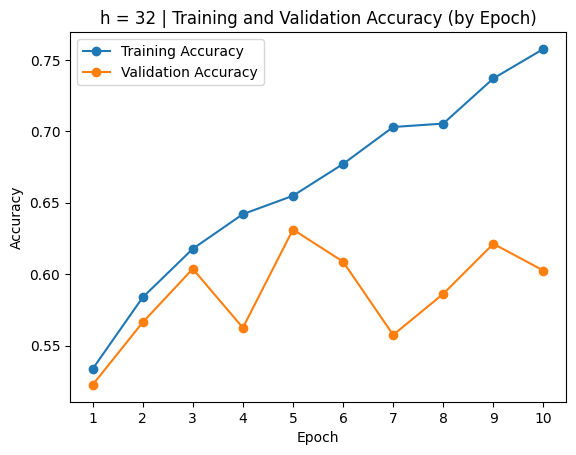

========== Training for 10 epochs | h = 64 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:07<00:00, 63.73it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.524625
Validation started for epoch 1


100%|██████████| 50/50 [00:00<00:00, 106.71it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.575
Training started for epoch 2


100%|██████████| 500/500 [00:07<00:00, 65.75it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.587125
Validation started for epoch 2


100%|██████████| 50/50 [00:00<00:00, 130.42it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.55625
Training started for epoch 3


100%|██████████| 500/500 [00:07<00:00, 64.83it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.611625
Validation started for epoch 3


100%|██████████| 50/50 [00:00<00:00, 130.75it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.5625
Training started for epoch 4


100%|██████████| 500/500 [00:07<00:00, 67.00it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.64175
Validation started for epoch 4


100%|██████████| 50/50 [00:00<00:00, 129.99it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.60625
Training started for epoch 5


100%|██████████| 500/500 [00:07<00:00, 68.58it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.66075
Validation started for epoch 5


100%|██████████| 50/50 [00:00<00:00, 127.48it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.60875
Training started for epoch 6


100%|██████████| 500/500 [00:07<00:00, 67.82it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.689375
Validation started for epoch 6


100%|██████████| 50/50 [00:00<00:00, 128.02it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.62
Training started for epoch 7


100%|██████████| 500/500 [00:07<00:00, 67.89it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 0.711875
Validation started for epoch 7


100%|██████████| 50/50 [00:00<00:00, 129.39it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 0.5925
Training started for epoch 8


100%|██████████| 500/500 [00:07<00:00, 68.06it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 0.733625
Validation started for epoch 8


100%|██████████| 50/50 [00:00<00:00, 129.04it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 0.625
Training started for epoch 9


100%|██████████| 500/500 [00:07<00:00, 69.75it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 0.751625
Validation started for epoch 9


100%|██████████| 50/50 [00:00<00:00, 130.31it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 0.6175
Training started for epoch 10


100%|██████████| 500/500 [00:07<00:00, 69.53it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 0.773
Validation started for epoch 10


100%|██████████| 50/50 [00:00<00:00, 128.00it/s]


Validation completed for epoch 10
Validation accuracy for epoch 10: 0.62625


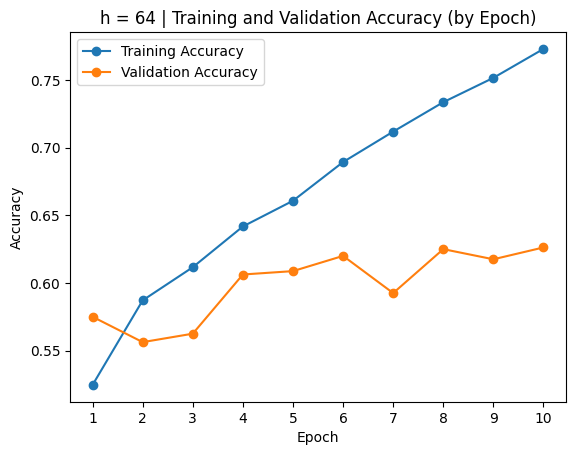

========== Training for 10 epochs | h = 128 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:10<00:00, 49.89it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.528
Validation started for epoch 1


100%|██████████| 50/50 [00:00<00:00, 118.73it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.49375
Training started for epoch 2


100%|██████████| 500/500 [00:10<00:00, 49.84it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.5945
Validation started for epoch 2


100%|██████████| 50/50 [00:00<00:00, 122.39it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.57625
Training started for epoch 3


100%|██████████| 500/500 [00:09<00:00, 50.22it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.625
Validation started for epoch 3


100%|██████████| 50/50 [00:00<00:00, 122.95it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.59125
Training started for epoch 4


100%|██████████| 500/500 [00:10<00:00, 49.78it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.652375
Validation started for epoch 4


100%|██████████| 50/50 [00:00<00:00, 118.95it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.5925
Training started for epoch 5


100%|██████████| 500/500 [00:09<00:00, 50.11it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.6635
Validation started for epoch 5


100%|██████████| 50/50 [00:00<00:00, 120.25it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.605
Training started for epoch 6


100%|██████████| 500/500 [00:10<00:00, 48.83it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.6965
Validation started for epoch 6


100%|██████████| 50/50 [00:00<00:00, 113.51it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.615
Training started for epoch 7


100%|██████████| 500/500 [00:09<00:00, 50.23it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 0.711375
Validation started for epoch 7


100%|██████████| 50/50 [00:00<00:00, 117.81it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 0.565
Training started for epoch 8


100%|██████████| 500/500 [00:09<00:00, 52.82it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 0.731375
Validation started for epoch 8


100%|██████████| 50/50 [00:00<00:00, 130.53it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 0.61125
Training started for epoch 9


100%|██████████| 500/500 [00:09<00:00, 54.17it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 0.755
Validation started for epoch 9


100%|██████████| 50/50 [00:00<00:00, 131.17it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 0.60625
Training started for epoch 10


100%|██████████| 500/500 [00:09<00:00, 54.23it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 0.775
Validation started for epoch 10


100%|██████████| 50/50 [00:00<00:00, 132.05it/s]


Validation completed for epoch 10
Validation accuracy for epoch 10: 0.56


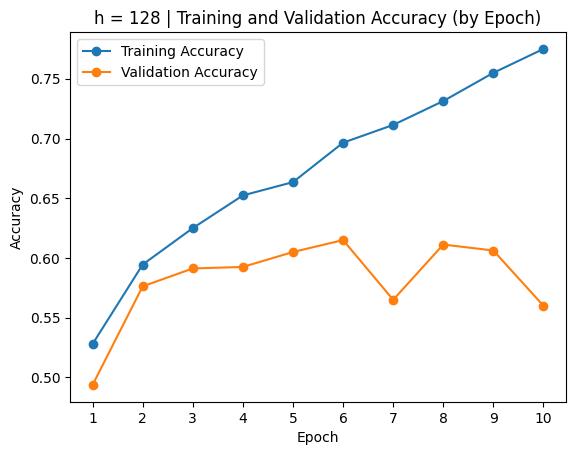

========== Training for 10 epochs | h = 256 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:14<00:00, 34.10it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.517375
Validation started for epoch 1


100%|██████████| 50/50 [00:00<00:00, 103.45it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.5525
Training started for epoch 2


100%|██████████| 500/500 [00:14<00:00, 33.97it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.580125
Validation started for epoch 2


100%|██████████| 50/50 [00:00<00:00, 103.44it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.555
Training started for epoch 3


100%|██████████| 500/500 [00:14<00:00, 33.82it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.61275
Validation started for epoch 3


100%|██████████| 50/50 [00:00<00:00, 102.74it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.58625
Training started for epoch 4


100%|██████████| 500/500 [00:14<00:00, 33.34it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.64925
Validation started for epoch 4


100%|██████████| 50/50 [00:00<00:00, 102.19it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.58125
Training started for epoch 5


100%|██████████| 500/500 [00:15<00:00, 32.83it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.66075
Validation started for epoch 5


100%|██████████| 50/50 [00:00<00:00, 103.05it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.60125
Training started for epoch 6


100%|██████████| 500/500 [00:15<00:00, 33.31it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.68875
Validation started for epoch 6


100%|██████████| 50/50 [00:00<00:00, 102.12it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.55
Training started for epoch 7


100%|██████████| 500/500 [00:15<00:00, 31.69it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 0.704
Validation started for epoch 7


100%|██████████| 50/50 [00:00<00:00, 97.36it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 0.61875
Training started for epoch 8


100%|██████████| 500/500 [00:15<00:00, 32.22it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 0.72675
Validation started for epoch 8


100%|██████████| 50/50 [00:00<00:00, 98.42it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 0.5725
Training started for epoch 9


100%|██████████| 500/500 [00:15<00:00, 32.38it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 0.748875
Validation started for epoch 9


100%|██████████| 50/50 [00:00<00:00, 97.14it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 0.6075
Training started for epoch 10


100%|██████████| 500/500 [00:15<00:00, 31.73it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 0.76925
Validation started for epoch 10


100%|██████████| 50/50 [00:00<00:00, 97.16it/s]


Validation completed for epoch 10
Validation accuracy for epoch 10: 0.57125


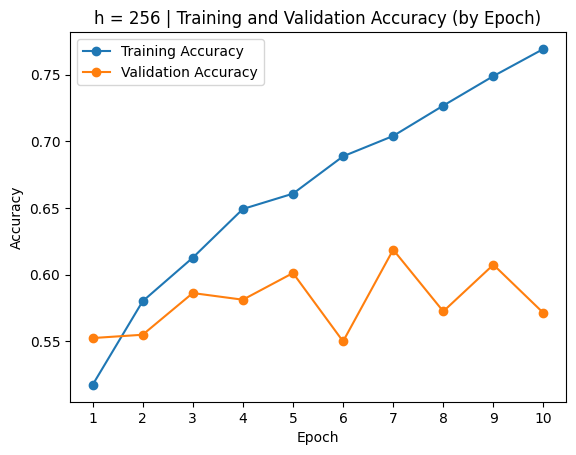

========== Training for 10 epochs | h = 512 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:28<00:00, 17.75it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.528375
Validation started for epoch 1


100%|██████████| 50/50 [00:00<00:00, 67.27it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.565
Training started for epoch 2


100%|██████████| 500/500 [00:27<00:00, 18.00it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.58625
Validation started for epoch 2


100%|██████████| 50/50 [00:00<00:00, 65.35it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.58875
Training started for epoch 3


100%|██████████| 500/500 [00:27<00:00, 18.19it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.618625
Validation started for epoch 3


100%|██████████| 50/50 [00:00<00:00, 65.11it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.60625
Training started for epoch 4


100%|██████████| 500/500 [00:27<00:00, 17.95it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.6415
Validation started for epoch 4


100%|██████████| 50/50 [00:00<00:00, 64.98it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.595
Training started for epoch 5


100%|██████████| 500/500 [00:27<00:00, 18.02it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.672625
Validation started for epoch 5


100%|██████████| 50/50 [00:00<00:00, 65.92it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.605
Training started for epoch 6


100%|██████████| 500/500 [00:27<00:00, 18.26it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.691
Validation started for epoch 6


100%|██████████| 50/50 [00:00<00:00, 67.95it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.60875
Training started for epoch 7


100%|██████████| 500/500 [00:26<00:00, 18.56it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 0.72475
Validation started for epoch 7


100%|██████████| 50/50 [00:00<00:00, 65.64it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 0.57875
Training started for epoch 8


100%|██████████| 500/500 [00:27<00:00, 18.14it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 0.757125
Validation started for epoch 8


100%|██████████| 50/50 [00:00<00:00, 65.00it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 0.5525
Training started for epoch 9


100%|██████████| 500/500 [00:27<00:00, 18.32it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 0.7755
Validation started for epoch 9


100%|██████████| 50/50 [00:00<00:00, 64.74it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 0.58625
Training started for epoch 10


100%|██████████| 500/500 [00:27<00:00, 18.01it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 0.809
Validation started for epoch 10


100%|██████████| 50/50 [00:00<00:00, 64.37it/s]


Validation completed for epoch 10
Validation accuracy for epoch 10: 0.55375


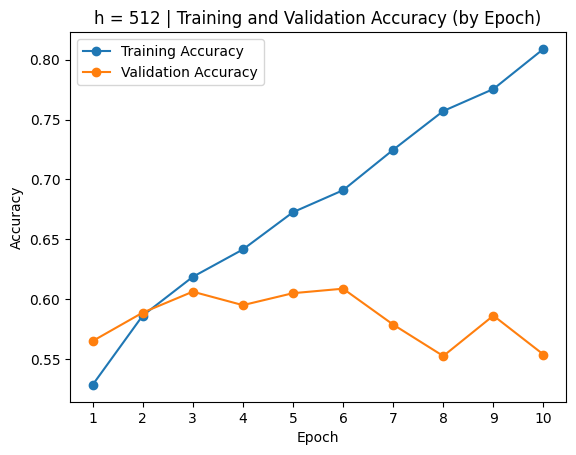

========== Training for 10 epochs | h = 1024 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:53<00:00,  9.36it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.51325
Validation started for epoch 1


100%|██████████| 50/50 [00:01<00:00, 40.22it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.58
Training started for epoch 2


100%|██████████| 500/500 [00:50<00:00,  9.84it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.58675
Validation started for epoch 2


100%|██████████| 50/50 [00:01<00:00, 40.36it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.53875
Training started for epoch 3


100%|██████████| 500/500 [00:50<00:00,  9.86it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.620625
Validation started for epoch 3


100%|██████████| 50/50 [00:01<00:00, 40.52it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.61
Training started for epoch 4


100%|██████████| 500/500 [00:50<00:00,  9.83it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.648375
Validation started for epoch 4


100%|██████████| 50/50 [00:01<00:00, 39.99it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.605
Training started for epoch 5


100%|██████████| 500/500 [00:50<00:00,  9.82it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.671
Validation started for epoch 5


100%|██████████| 50/50 [00:01<00:00, 40.52it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.6025
Training started for epoch 6


100%|██████████| 500/500 [00:50<00:00,  9.81it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.688625
Validation started for epoch 6


100%|██████████| 50/50 [00:01<00:00, 40.09it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.5475
Training started for epoch 7


100%|██████████| 500/500 [00:50<00:00,  9.83it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 0.729625
Validation started for epoch 7


100%|██████████| 50/50 [00:01<00:00, 39.76it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 0.61125
Training started for epoch 8


100%|██████████| 500/500 [00:51<00:00,  9.74it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 0.74875
Validation started for epoch 8


100%|██████████| 50/50 [00:01<00:00, 38.40it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 0.6075
Training started for epoch 9


100%|██████████| 500/500 [00:50<00:00,  9.98it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 0.799625
Validation started for epoch 9


100%|██████████| 50/50 [00:01<00:00, 40.04it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 0.5925
Training started for epoch 10


100%|██████████| 500/500 [00:51<00:00,  9.77it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 0.818375
Validation started for epoch 10


100%|██████████| 50/50 [00:01<00:00, 40.36it/s]


Validation completed for epoch 10
Validation accuracy for epoch 10: 0.605


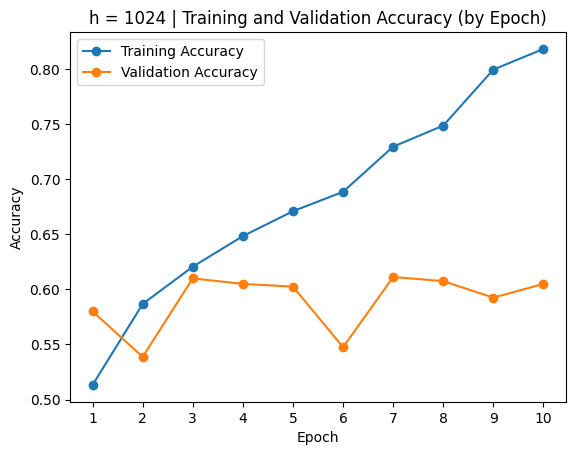

In [75]:
# Training and Validation
for hidden_dim in args.hidden_dims:
    # Create model and optimizer
    model = FFNN(input_dim=len(vocab), h=hidden_dim)
    model.to(device)  # move model to device
    train_acc, val_acc = train_and_val(model)
    plot(train_acc, val_acc, hidden_dim)

In [76]:
# Testing